In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC


In [31]:
url = "https://www.consumerfinance.gov/data-research/consumer-complaints/search/api/v1/?date_received_max=2017-06-04&date_received_min=2014-06-04&field=all&format=csv&has_narrative=true&no_aggs=true&size=10000"

df = pd.read_csv(url)
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
print(df['product'].unique())

['Mortgage' 'Credit card' 'Debt collection' 'Credit reporting'
 'Bank account or service' 'Student loan' 'Consumer Loan' 'Payday loan'
 'Prepaid card' 'Money transfer, virtual currency, or money service'
 'Credit reporting, credit repair services, or other personal consumer reports'
 'Vehicle loan or lease' 'Checking or savings account'
 'Payday loan, title loan, or personal loan' 'Credit card or prepaid card'
 'Money transfers' 'Other financial service' 'Virtual currency']


In [32]:
label_map = {
    "Credit reporting, credit repair services, or other personal consumer reports": 0,
    "Debt collection": 1,
    "Consumer Loan": 2,
    "Mortgage": 3
}


In [33]:
# Filtering the rows with both product and consumer complaint narrative
df = df[['product', 'consumer_complaint_narrative']].dropna()
df = df[df['product'].isin(label_map.keys())]
df['label'] = df['product'].map(label_map)
print("Label counts:")
print(df['label'].value_counts())


Label counts:
label
1    43318
3    34451
2     9461
0     4989
Name: count, dtype: int64


In [34]:
#Sampling to get a balanced dataset
from sklearn.utils import resample
dfs = []
min_count = df['label'].value_counts().min()

for label in df['label'].unique():
    df_label = df[df['label'] == label]
    df_downsampled = resample(df_label,
                              replace=False,
                              n_samples=min_count,
                              random_state=42)
    dfs.append(df_downsampled)

df_balanced = pd.concat(dfs)

print("Balanced dataset label counts:")
print(df_balanced['label'].value_counts())


Balanced dataset label counts:
label
3    4989
1    4989
2    4989
0    4989
Name: count, dtype: int64


In [35]:
#test and train dataset
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
X = df_balanced['consumer_complaint_narrative']
y = df_balanced['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
tfidf = TfidfVectorizer(stop_words='english', max_df=0.7, min_df=5, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


Classification Report for Logistic Regression:

              precision    recall  f1-score   support

           0       0.85      0.90      0.87       998
           1       0.87      0.87      0.87       998
           2       0.88      0.84      0.86       998
           3       0.95      0.93      0.94       998

    accuracy                           0.89      3992
   macro avg       0.89      0.89      0.89      3992
weighted avg       0.89      0.89      0.89      3992



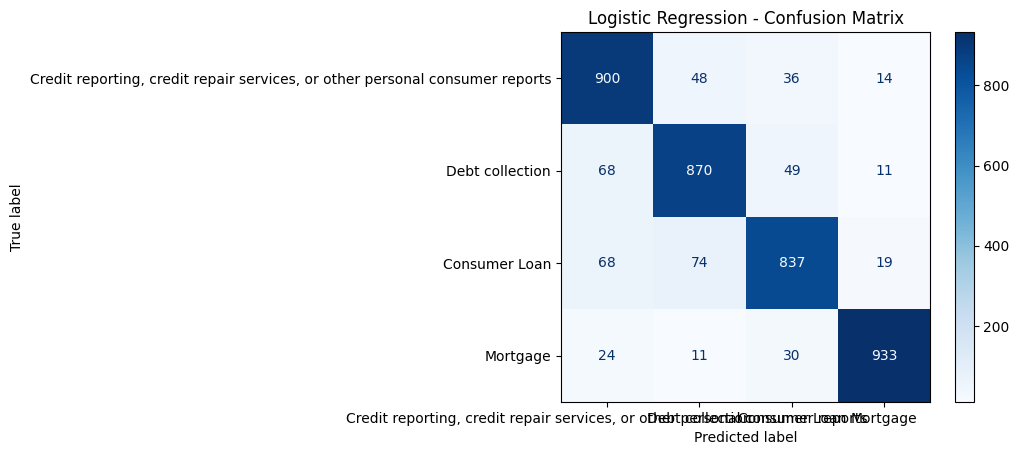

Classification Report for SVM:

              precision    recall  f1-score   support

           0       0.86      0.92      0.89       998
           1       0.87      0.87      0.87       998
           2       0.89      0.85      0.87       998
           3       0.96      0.93      0.94       998

    accuracy                           0.89      3992
   macro avg       0.89      0.89      0.89      3992
weighted avg       0.89      0.89      0.89      3992



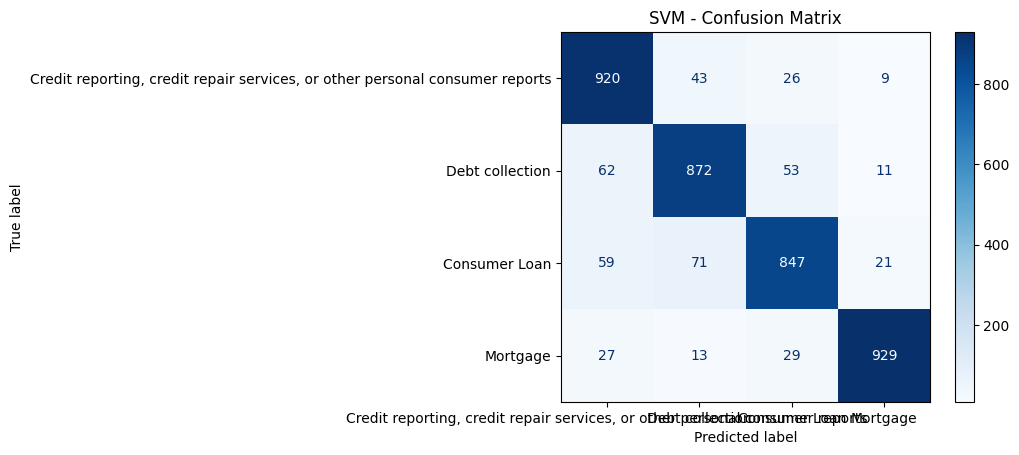

Classification Report for Gaussian Naive Bayes:

              precision    recall  f1-score   support

           0       0.81      0.84      0.83       998
           1       0.79      0.60      0.68       998
           2       0.70      0.78      0.74       998
           3       0.83      0.91      0.87       998

    accuracy                           0.78      3992
   macro avg       0.78      0.78      0.78      3992
weighted avg       0.78      0.78      0.78      3992



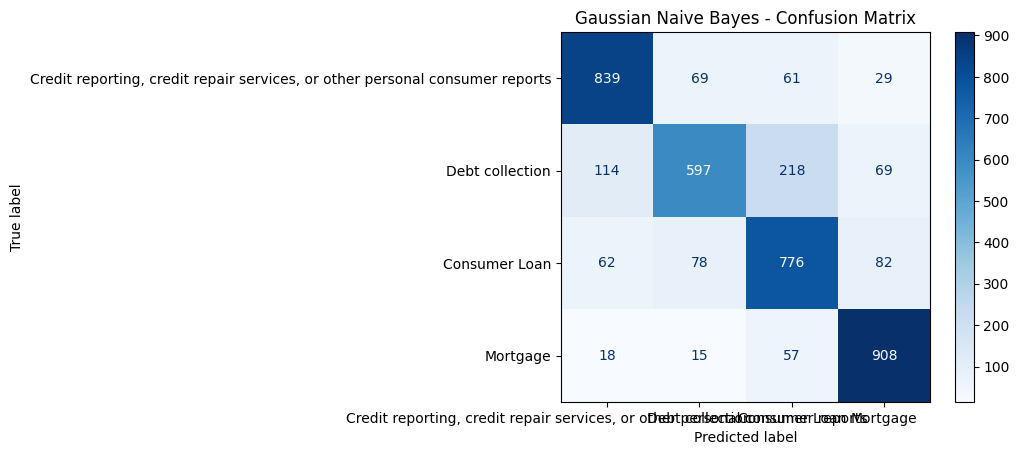

Classification Report for Random Forest:

              precision    recall  f1-score   support

           0       0.87      0.92      0.89       998
           1       0.85      0.86      0.86       998
           2       0.88      0.81      0.84       998
           3       0.93      0.94      0.93       998

    accuracy                           0.88      3992
   macro avg       0.88      0.88      0.88      3992
weighted avg       0.88      0.88      0.88      3992



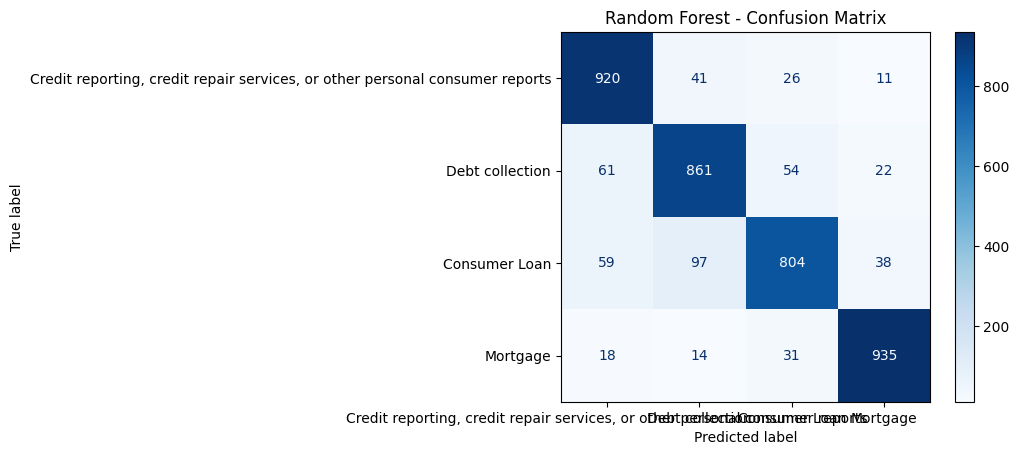

In [36]:
#Using different models for classification
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Logistic Regression
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_tfidf, y_train)
y_pred_lr = lr.predict(X_test_tfidf)

# Support Vector Machine (SVM)
svm = SVC(kernel='linear', random_state=42)
svm.fit(X_train_tfidf, y_train)
y_pred_svm = svm.predict(X_test_tfidf)

# Naive Bayes
gnb = GaussianNB()
X_train_dense = X_train_tfidf.toarray()
X_test_dense = X_test_tfidf.toarray()
gnb.fit(X_train_dense, y_train)
y_pred_gnb = gnb.predict(X_test_dense)

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_tfidf, y_train)
y_pred_rf = rf.predict(X_test_tfidf)

# Confusion matrix
def print_report(y_true, y_pred, model_name):
    print(f"Classification Report for {model_name}:\n")
    print(classification_report(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label_map.keys()))
    disp.plot(cmap="Blues")
    plt.title(f"{model_name} - Confusion Matrix")
    plt.show()

# Print reports
print_report(y_test, y_pred_lr, "Logistic Regression")
print_report(y_test, y_pred_svm, "SVM")
print_report(y_test, y_pred_gnb, "Gaussian Naive Bayes")
print_report(y_test, y_pred_rf, "Random Forest")


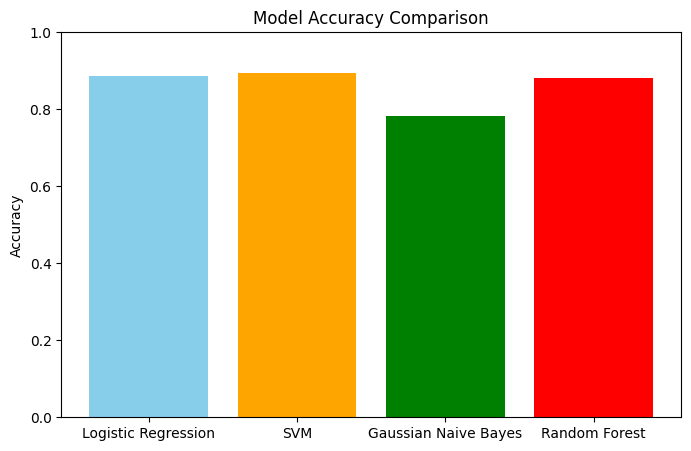

Accuracies:
Logistic Regression: 0.8868
SVM: 0.8938
Gaussian Naive Bayes: 0.7816
Random Forest: 0.8818


In [37]:
#Comparing different models
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
models = {
    "Logistic Regression": y_pred_lr,
    "SVM": y_pred_svm,
    "Gaussian Naive Bayes": y_pred_gnb,
    "Random Forest": y_pred_rf
}
accuracies = {name: accuracy_score(y_test, preds) for name, preds in models.items()}
plt.figure(figsize=(8,5))
plt.bar(accuracies.keys(), accuracies.values(), color=['skyblue','orange','green','red'])
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.ylim([0,1])
plt.show()
print("Accuracies:")
for model_name, acc in accuracies.items():
    print(f"{model_name}: {acc:.4f}")


In [38]:
# Prediction
new_texts = [
    "I found incorrect items on my credit report.",
    "They keep calling me about a debt I do not owe.",
    "My loan application was denied without explanation.",
    "My mortgage servicer is charging me too much."
]
new_texts_tfidf = tfidf.transform(new_texts)
predictions = lr.predict(new_texts_tfidf)
inv_label_map = {v: k for k, v in label_map.items()}
for text, pred in zip(new_texts, predictions):
    print(f"Text: {text}\nPredicted Category: {inv_label_map[pred]}\n")

Text: I found incorrect items on my credit report.
Predicted Category: Credit reporting, credit repair services, or other personal consumer reports

Text: They keep calling me about a debt I do not owe.
Predicted Category: Debt collection

Text: My loan application was denied without explanation.
Predicted Category: Consumer Loan

Text: My mortgage servicer is charging me too much.
Predicted Category: Mortgage

